In [1]:
import numpy as np
import pandas as pd

from bambi import Model

import altair as alt
from altair.expr import datum

In [2]:
%load_ext watermark

In [3]:
%watermark --iversions

numpy     1.16.3
pandas    0.24.2
altair    2.4.1



## Calculate branch points data

In [272]:
def get_branch_points():
    return [
        {"name": "EMP_PPP", "one": "PGI", "two": "G6PDH2r"},  # EMP vs PPP
        {"name": "PYK_PPC", "one": "PYK", "two": "PPC"},  # Pyruvate via Pyk ior PEP
        {"name": "TCA_ACE", "one": "CS", "two": "PTAr"},  # TCA vs Acetate execretion 
    ]

In [273]:
def calc_branch_stat(df):
    # Supposed to be called after grouping by sample_id
    df = df.set_index(["BiGG_ID", "author"])

    res = {
        branch["name"]: df.loc[branch["one"], "normalized_flux"]
        / (
            df.loc[branch["one"], "normalized_flux"]
            + df.loc[branch["two"], "normalized_flux"]
        )
        for branch in get_branch_points()
    }
    return(pd.DataFrame(res))

In [274]:
knockouts_data = pd.read_csv("../data/processed/knockouts.csv", index_col=0)

In [275]:
knockouts_data.head()

,BiGG_ID,sample_id,author,flux,normalized_flux,relative_error
0,AKGDH,WT,ECC2,0.000000,0.000000,1000.000000
1,AKGDH,WT,Ec_core,1.205823,42.161639,39.937635
2,AKGDH,WT,Exp_ECC2,1.619273,58.669298,0.563671
3,AKGDH,WT,Exp_iML1515,1.740514,61.035954,3.335663
4,AKGDH,WT,Ishii,1.687400,59.000000,0.000000


In [276]:
branch_data = knockouts_data.groupby("sample_id").apply(calc_branch_stat)

In [279]:
x_branch_data = branch_data.to_xarray()

In [286]:
x_mape_branch = (abs(x_branch_data - x_branch_data.sel(author="Ishii"))/abs(x_branch_data.sel(author="Ishii")))*100

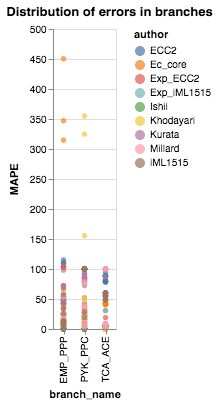

In [302]:
alt.Chart(
    data=x_mape_branch.to_dataframe()
    .reset_index()
    .melt(
        value_vars=["EMP_PPP", "PYK_PPC", "TCA_ACE"],
        id_vars=["author", "sample_id"],
        var_name="branch_name",
        value_name = "MAPE"
    ),
    title="Distribution of errors in branches",
).mark_circle().encode(x=alt.X("branch_name:N"), y=alt.Y("MAPE:Q"), color = "author:N").transform_filter("datum.MAPE < 1000")

## Calculate flux-type errors

In [9]:
# BiGG_ID : Class
# Class is one of the following
# EMP, PPP, Pyr, TCA, EDD/EDA, Uptake
def get_flux_map():
    return {
        "AKGDH": "TCA",
        "CS": "TCA",
        "EDA": "EDA",
        "FBA": "EMP",
        "FUM": "TCA",
        "G6PDH2r": "PPP",
        "GAPD": "EMP",
        "GLCptspp": "Uptake",
        "GND": "PPP",
        "ICDHyr": "TCA",
        "ICL": "TCA",
        "MALS": "TCA",
        "MDH": "TCA",
        "PDH": "Pyr",
        "PGI": "EMP",
        "PGM": "EMP",
        "PPC": "Pyr",
        "PTAr": "Pyr",
        "PYK": "Pyr",
        "RPE": "PPP",
        "RPI": "PPP",
        "SUCDi": "TCA",
        "TALA": "PPP",
        "TKT1": "PPP",
        "TPI": "EMP",
    }

In [187]:
df = knockouts_data
df['subsystem'] = df.apply(lambda x: get_flux_map()[x.BiGG_ID], axis=1)
df.loc[df.relative_error.isna(), "relative_error"] = 0.0

uptake_num = 1
tca_num = 8

### Are there any subsystems that are consistently harder to predict regardless of which model we use?
Statistical model for such question is this - $ \text{normalized_error} \sim C(\text{subsystem}) + \text{error} $. That is essentialy ANOVA, but specified as GLM.

Usually there are [two ways](http://www.flutterbys.com.au/stats/tut/tut7.4b.html#h3_33) of defining such GLMs -  the *Means parametrization* and the *Effects parametrization*. Usually people use effects parametrization. Here the intercept describes effect of Group 1 and the $\beta_{2}$ describe changes to $y$ if the group is changed from 1 to 2.

Then we will investigate what will happen if `model` is also added as factor

In [188]:
df = df.query("author != 'Ishii' and author != 'Ec_core'")

In [190]:
subsystem_list = ["Uptake", "EMP", "EDA", "PPP", "Pyr", "TCA"]
df['subsystem'] = pd.Categorical(df.subsystem, categories=subsystem_list, ordered=True)

/Users/denshe/anaconda3/envs/dataml/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [192]:
models_list = ["iML1515", "Khodayari", "Kurata", "Millard", "ECC2", "Exp_ECC2"]
df['author'] = pd.Categorical(df.author, categories=models_list, ordered=True)

/Users/denshe/anaconda3/envs/dataml/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [224]:
dots = (
    alt.Chart(df)
    .mark_circle(size=80)
    .encode(
        y=alt.Y("relative_error"),
        x=alt.X("subsystem:N", sort=subsystem_list),
        color=alt.Color("sample_id:N"),
        tooltip=["author", "sample_id", "BiGG_ID"],
    )
)

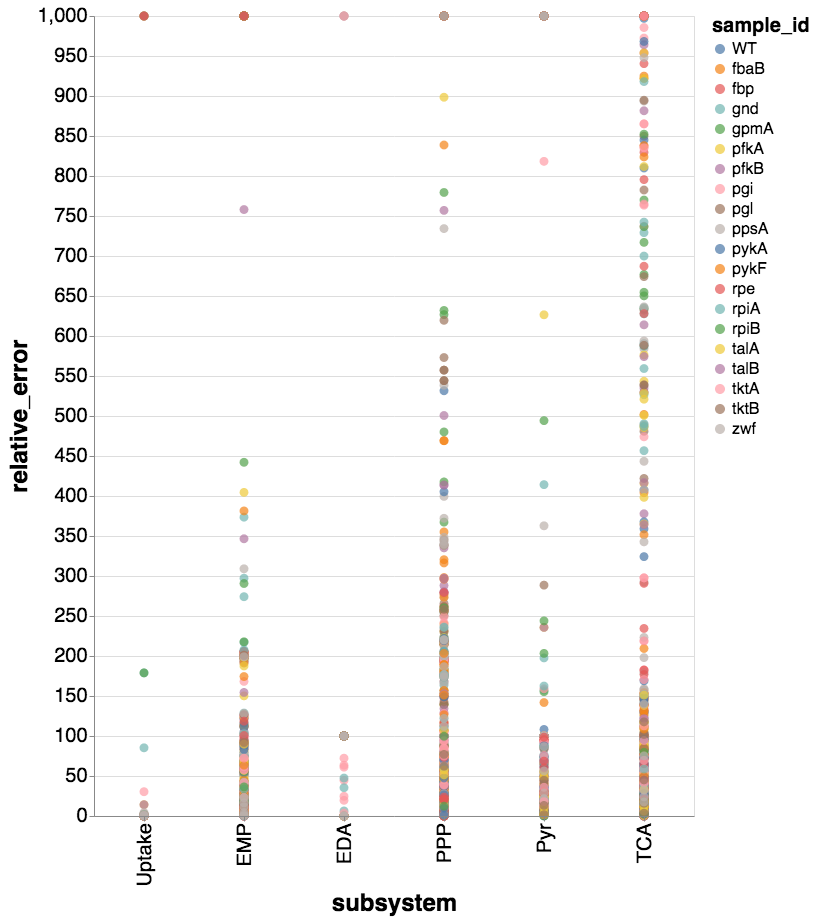

In [225]:
dots.properties(width=600, height=800).configure_axis(
    labelFontSize=20, titleFontSize=24
).configure_legend(labelFontSize=16, titleFontSize=20)

In [195]:
model = Model(df.sort_values(["author", "subsystem"]))

### Specify one-way ANOVA
`relative_error ~ subsystem`

In [201]:
results = model.fit("relative_error ~ subsystem")

/Users/denshe/anaconda3/envs/dataml/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [relative_error_sd, subsystem, Intercept]
100%|██████████| 1500/1500 [00:05<00:00, 292.00it/s]
The number of effective samples is smaller than 25% for some parameters.


In [202]:
model.backend.model

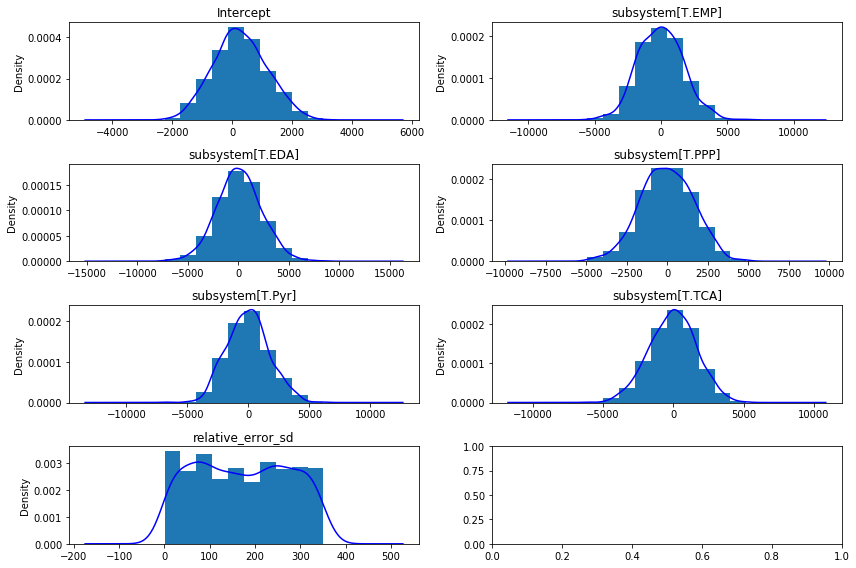

In [203]:
model.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2cb3f860>,
      dtype=object)

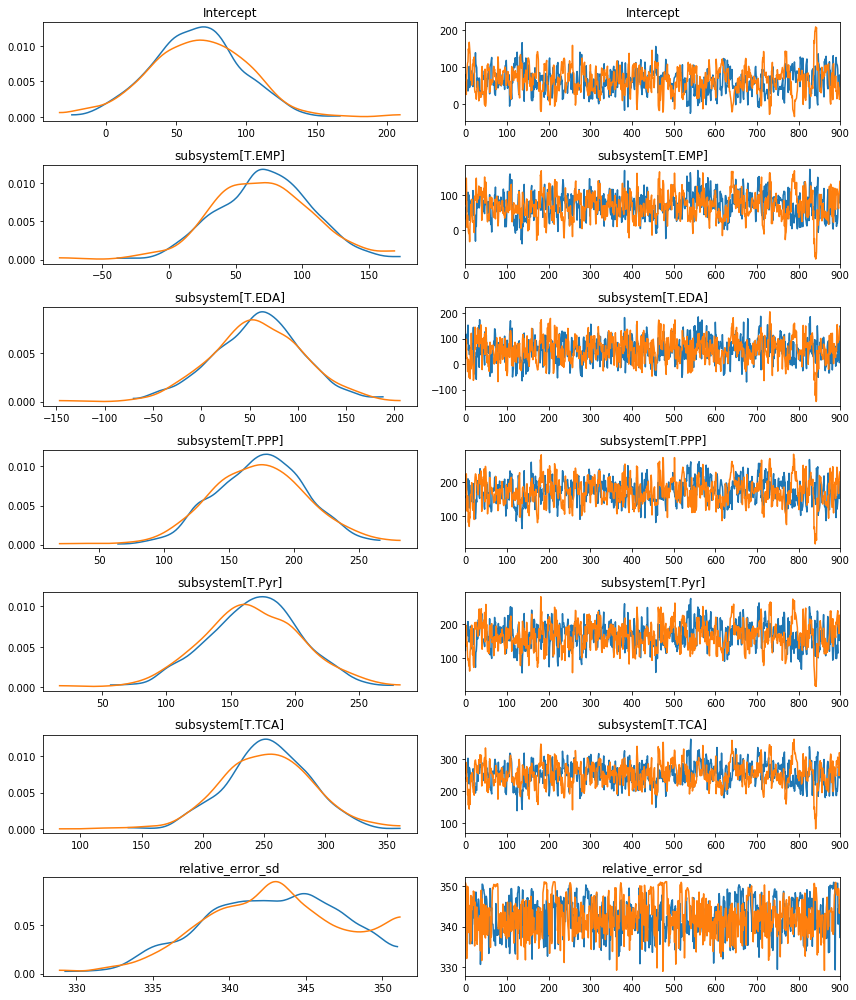

In [204]:
results[100:].plot()

In [205]:
results[100:].summary()

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
Intercept,64.885545,33.270835,-0.920812,125.627063,350.695137,1.000220
subsystem[T.EMP],70.546749,36.163759,0.810961,140.952228,395.784945,1.000632
subsystem[T.EDA],58.143129,46.681933,-29.242899,155.910789,553.018387,0.999468
subsystem[T.PPP],173.580425,36.092709,108.734592,247.402037,404.230236,0.999769
subsystem[T.Pyr],167.293840,37.735720,93.394851,238.151238,387.556932,1.000115
subsystem[T.TCA],252.463342,34.985605,183.788172,316.194574,375.913421,0.999977
relative_error_sd,342.680840,4.454164,335.057072,351.133140,582.637480,0.999784


### What can be explained with addition of the model as factor?
We will use iML1515 as baseline which would be improved by every other model

In [206]:
results = model.fit("relative_error ~ subsystem + author")

/Users/denshe/anaconda3/envs/dataml/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [relative_error_sd, author, subsystem, Intercept]
100%|██████████| 1500/1500 [00:08<00:00, 183.21it/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2ffcbe80>,
      dtype=object)

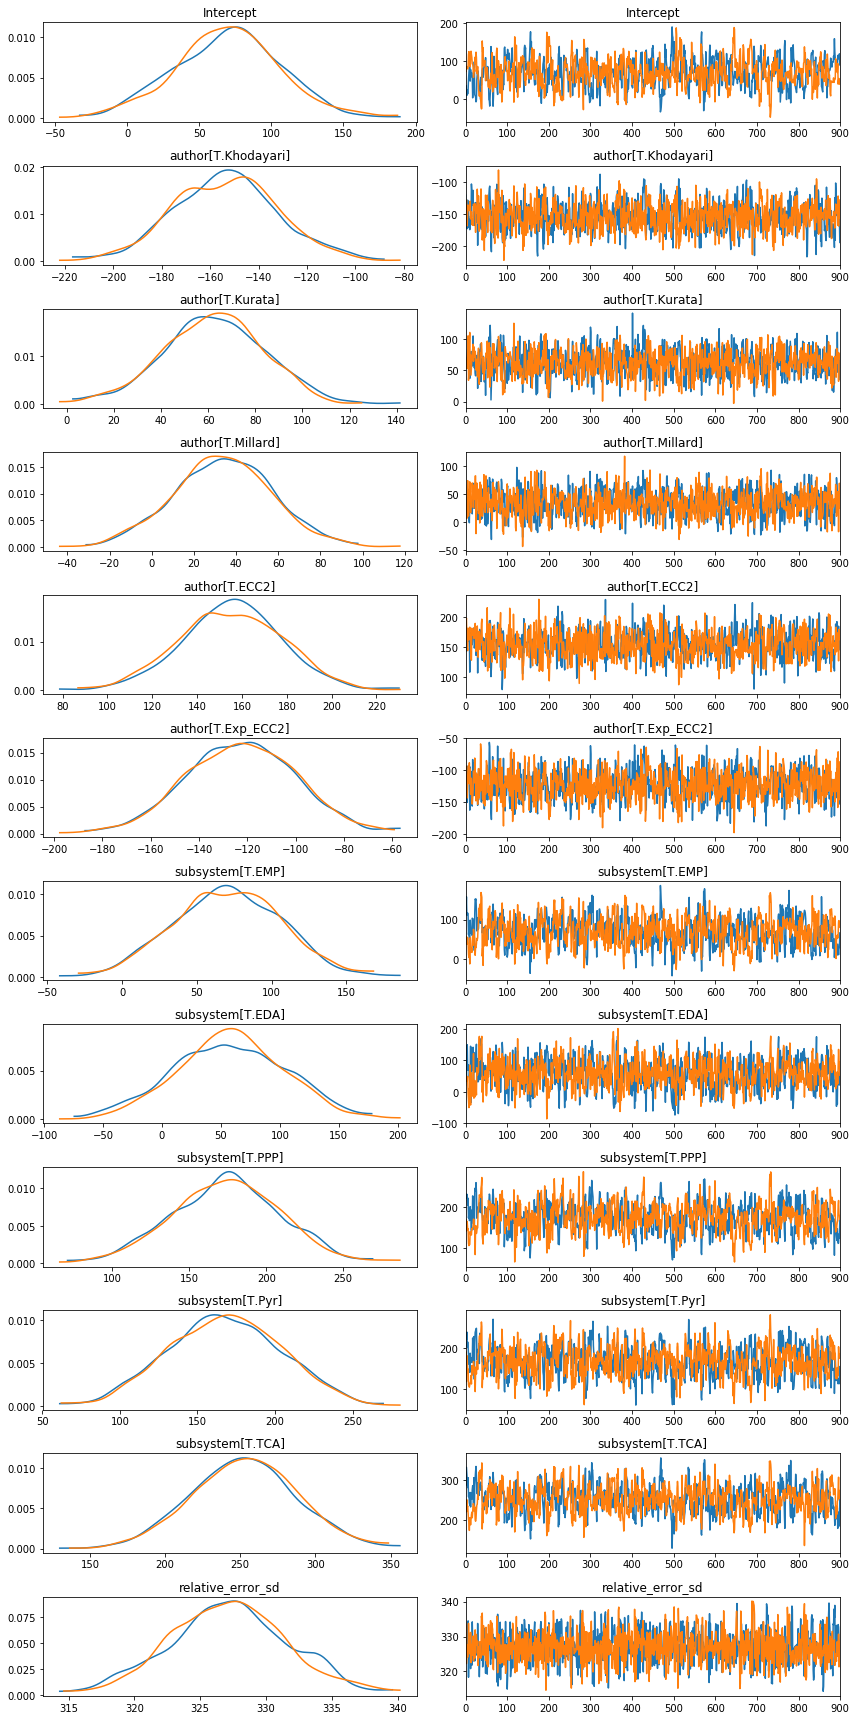

In [207]:
results[100:].plot()

In [208]:
results[100:].summary()

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
Intercept,69.349845,36.328912,-7.312640,134.847687,441.349744,0.999445
author[T.Khodayari],-153.739864,21.246064,-191.512204,-107.127087,978.441320,0.999474
author[T.Kurata],62.095312,20.918652,20.723681,102.413819,898.910716,1.000279
author[T.Millard],33.749756,22.767124,-15.738144,74.275532,912.329248,0.999673
author[T.ECC2],155.179030,22.421540,108.677811,195.772087,1012.184252,1.000054
author[T.Exp_ECC2],-122.754548,22.493616,-166.334852,-79.475331,989.399991,0.999444
subsystem[T.EMP],70.249917,35.954605,1.779764,138.606185,459.622551,0.999473
subsystem[T.EDA],57.410347,46.272050,-33.167748,145.604000,597.715298,0.999951
subsystem[T.PPP],173.890544,35.227965,107.936896,242.572231,427.172603,0.999532
subsystem[T.Pyr],167.355066,36.237425,100.030615,236.644135,464.874907,0.999623


### How similar are errors in one subsystem?

In [22]:
def corr_within_subsystem(df, subsystem):
    if subsystem in subsystem_list:
        return (
            df.query(f"subsystem == '{subsystem}'")
            .drop(["subsystem", "flux", "normalized_flux"], axis=1)
            .set_index(["author", "sample_id", "BiGG_ID"])
            .unstack("BiGG_ID")
            .corr(method="pearson")
        )
    else:
        raise ValueError(
            f"Value should be one of {', '.join(list(set(get_flux_map().values())))}"
        )

In [23]:
corr_within_subsystem(df, "PPP")

relative_error                                          \
BiGG_ID                       G6PDH2r       GND       RPE       RPI      TALA   
               BiGG_ID                                                          
relative_error G6PDH2r       1.000000  0.829688  0.476402  0.538431  0.500425   
               GND           0.829688  1.000000  0.560797  0.737792  0.487934   
               RPE           0.476402  0.560797  1.000000  0.729336  0.538678   
               RPI           0.538431  0.737792  0.729336  1.000000  0.569927   
               TALA          0.500425  0.487934  0.538678  0.569927  1.000000   
               TKT1          0.522956  0.549214  0.679931  0.596415  0.734696   

                                  
BiGG_ID                     TKT1  
               BiGG_ID            
relative_error G6PDH2r  0.522956  
               GND      0.549214  
               RPE      0.679931  
               RPI      0.596415  
               TALA     0.734696  
               TKT1     1.000000

In [24]:
corr_within_subsystem(df, "TCA")

relative_error                                          \
BiGG_ID                         AKGDH        CS       FUM    ICDHyr       ICL   
               BiGG_ID                                                          
relative_error AKGDH         1.000000  0.917502  0.925474  0.958188  0.447951   
               CS            0.917502  1.000000  0.993829  0.865750  0.580139   
               FUM           0.925474  0.993829  1.000000  0.890344  0.551040   
               ICDHyr        0.958188  0.865750  0.890344  1.000000  0.373002   
               ICL           0.447951  0.580139  0.551040  0.373002  1.000000   
               MALS          0.440983  0.574664  0.545781  0.367167  0.999279   
               MDH           0.876606  0.963268  0.958142  0.805958  0.633703   
               SUCDi         0.924309  0.989087  0.977744  0.842946  0.591137   

                                                      
BiGG_ID                     MALS       MDH     SUCDi  
               BiGG_ID                                
relative_error AKGDH    0.440983  0.876606  0.924309  
               CS       0.574664  0.963268  0.989087  
               FUM      0.545781  0.958142  0.977744  
               ICDHyr   0.367167  0.805958  0.842946  
               ICL      0.999279  0.633703  0.591137  
               MALS     1.000000  0.628847  0.584376  
               MDH      0.628847  1.000000  0.963888  
               SUCDi    0.584376  0.963888  1.000000

In [269]:
def heatmap(author):
    return (
        alt.Chart(
            df.query(f"author == '{author}'"), title=f"Heatmap for model {author}"
        )
        .mark_rect()
        .encode(
            x=alt.X("sample_id:N"),
            y=alt.Y("BiGG_ID:N"),
            color=alt.Color("mean(relative_error)", scale=alt.Scale(domain=[0,50,75,100,200,300], scheme="greenblue")),
            tooltip=["sample_id", "BiGG_ID", "relative_error"],
        )
    )

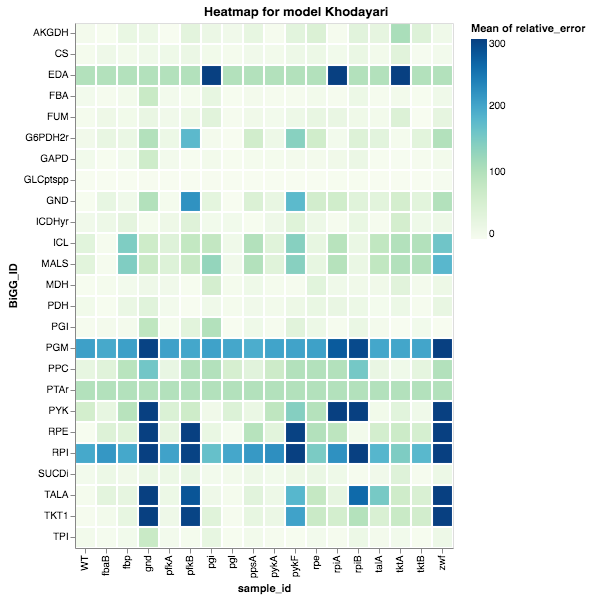

In [270]:
heatmap(author="Khodayari")

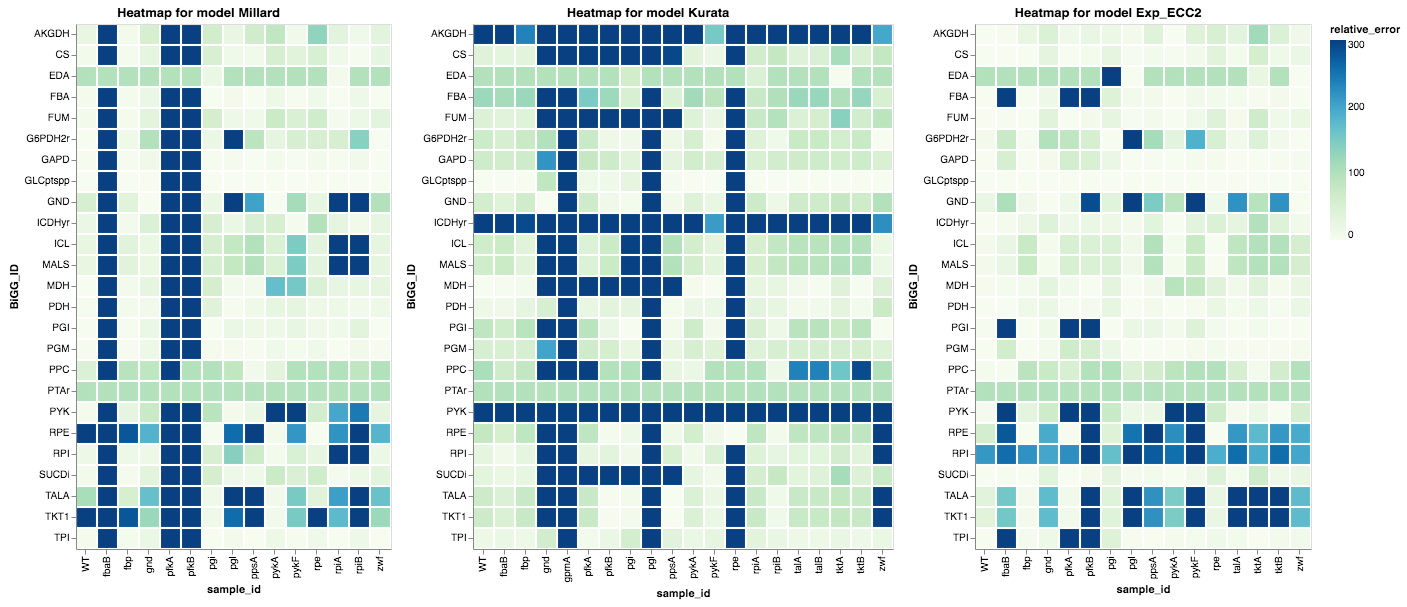

In [265]:
alt.hconcat(
    heatmap(author="Millard"), heatmap(author="Kurata"), heatmap(author="Exp_ECC2")
)